In [130]:
import os
from typing import  List
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import sqlite3

from yaml import load
from yaml import SafeLoader
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage
import json
import logging
from io import BytesIO
from typing import Annotated, Literal

from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from typing_extensions import TypedDict


In [131]:
INITIAL_PROMPT = """
You are a professional fitness coach and researcher with deep expertise in
exercise science, sports physiology, nutrition, strength training,
and athletic performance.

Your mission is to help people reach their fitness goals by:
- Analyzing their current fitness level, body weghit and height

WEGHIT:{weight}
HEIGHT:{tall}
GOAL:{goal}
intensity:{intensity}
age:{age}
sex:{sex}
Equipment: local gym
Here’s how we’ll collaborate:


1.Use your knowledge and tools to search for relevant exercises from a database
   and determine optimal sets, reps, and intensity based on the user's goals.
2. Organize the workout into a structured, goal-specific plan, categorized by
   body parts (e.g., back, chest, legs) and sub-muscle groups.
3. Allow for feedback, adjustments, and improvements based on user input or
   progress tracking.
4. Output the full program in a clean, structured format that includes:
   - Exercises with primary/secondary muscle groups
   - Instructions, sets, reps, and variations
   - Weekly split and progression strategies

THIS the list of all the primary mucsle names
:[
    'Biceps Brachii', 'Brachialis', 'Brachioradialis', 'Deltoid', 'Gluteus Maximus', 'Hamstrings',
    'Deltoid Lateral', 'biceps', 'brachialis', 'brachioradialis', 'chest', 'Anterior Deltoids',
    'Lateral Deltoids', 'Triceps Brachii', 'Upper Pectorals', 'Pectoralis Major', 'Triceps',
    'Latissimus Dorsi', 'Trapezius', 'Rhomboids', 'Deltoids', 'biceps femoris', 'semitendinosus',
    'semimembranosus', 'quads', 'glutes', 'Chest', 'Shoulders', 'Core', 'Rear Deltoids',
    'Rotator Cuff', 'Posterior Deltoids', 'Quadriceps', 'Hips', 'Gluteal muscles', 'Front Deltoids',
    'Lateral Deltoid', 'Rear Deltoid', 'Pectoralis', 'Pectoralis major', 'Erector Spinae',
    'adductors', 'inner thigh muscles', 'Lower Back', 'Middle Back', 'Gastrocnemius', 'Soleus',
    'lower back', 'Gluteus Medius', 'Gluteus Minimus', 'calves', 'Spinal Erectors',
    'forearm extensors', 'back', 'Pectoral muscles', 'Chest muscles', 'Medial Deltoid',
    'Serratus Anterior', 'Middle delts', 'Rear delts', 'Traps', 'Rectus Femoris', 'Vastus Medialis',
    'Back muscles', 'forearm muscles', 'latissimus dorsi', 'Wrist Flexor', 'Wrist Flexors',
    'Lateral Deltoids', 'Posterior Deltoids', 'Latissimus dorsi', 'Lower trapezius',
    'Pectoralis Minor', 'Pectoralis Major - Clavicular Head', 'Multifidus', 'lats', 'traps',
    'Vastus Lateralis', 'Vastus Intermedius', 'legs', 'Upper Back', 'Middle Trapezii',
    'Lower Trapezii', 'Teres Major', 'Teres Minor', 'Infraspinatus', 'delts', 'pecs',
    'Thenar muscles', 'Finger Flexors', 'Pectoral (Chest) Muscles'
]

THIS the list of all the secondary mucsle names
["['Calves', 'Abdominals']", "['Abs', 'Adductors', 'Lower Back', 'Shoulders', 'Traps', 'Upper Back']", "['Arms']", "['Lateral Deltoid', 'Trapezius', 'Rotator cuff muscles']", "['Shoulders', 'Biceps', 'Back']", "['Brachialis', 'Forearm muscles', 'Brachioradialis']", "['Rotator']", "['Posterior delts']", "['Glutes', 'Quads', 'Hamstrings']", "['Brachialis', 'Brachioradialis', 'Forearms']", "['Rhomboids']", "['Biceps', 'Trapezius', 'Rhomboids', 'Shoulders', 'Forearms']", "['Shoulders', 'Triceps', 'Core', 'Upper Back', 'Neck']", "['Triceps', 'Pecs', 'Shoulder Stabilizers', 'Upper Back Muscles']", "['Gastrocnemius']", "['Lower Back']", "['Serratus Anterior', 'Upper Back']", "['Quadriceps', 'Erectors', 'Adductor Magnus', 'Lats', 'Abs']", "['Hamstrings', 'Adductors', 'Abductors', 'Core muscles']", "['Shoulders', 'Triceps']", "['Biceps brachii', 'Brachialis', 'Brachioradialis', 'Rhomboids', 'Infraspinatus']", "['abs', 'obliques']", "['Posterior Deltoids', 'Upper Back Muscles']", "['Rhomboid Major', 'Rhomboid Minor']", "['Teres Minor', 'Shoulders', 'Triceps', 'Core']", "['core', 'upper body']", "['Upper Pectoralis', 'Trapezius', 'Serratus Anterior', 'Lateral Deltoid']", "['Tibialis Anterior', 'Soleus']", "['Shoulders', 'Core']", "['Anterior Deltoid', 'Triceps']", "['Quadriceps', 'Erectors', 'Trapezius', 'Rhomboids', 'Deltoids', 'Abdominals']", "['Triceps Brachii']", "['Lower leg', 'Core']", "['hip flexors', 'outer thighs']", "['Deltoids', 'Triceps']", "['Biceps', 'Shoulders']", "['Grip Muscles', 'Wrist Extensors']", "['Anterior Deltoids', 'Triceps']", "['Triceps', 'Upper Pectorals']", "['Abs', 'Back']", "['arms', 'shoulders', 'abs', 'core']", "['Lateral Deltoids', 'Trapezius', 'Upper Chest']", "['Calves', 'Gluteus Maximus', 'Gastrocnemius']", "['none']", "['glutes', 'deep core muscles', 'calf muscles']", "['Brachialis']", "['Calves', 'Glutes']", "['Traps']", "['Upper Back', 'Lower Traps', 'Abs', 'Upper Chest']", "['Biceps', 'Rear Deltoids']", "['biceps', 'triceps', 'forearm muscles']", "['Core']", "['Infraspinatus', 'Teres Minor']", "['Upper Chest', 'Trapezius', 'Biceps']", "['Chest', 'Shoulders', 'Teres major', 'Forearms', 'Core', 'Erector spinae', 'Hip flexors']", "['Anterior Deltoid', 'Triceps Brachii']", "['Brachioradialis', 'Forearm muscles']", "['Brachioradialis', 'Branchialis', 'Forearm muscles']", "['Brachialis', 'Brachioradialis', 'Wrist flexors', 'Obliques', 'Rectus abdominis']", "['Triceps', 'Trapezius', 'Rotator cuff muscles', 'Levator scapulae', 'Upper back']", "['Hamstrings', 'Core']", "['Biceps Brachii']", "['quads', 'hamstrings', 'core muscles']", "['Back', 'Core', 'Shoulders', 'Arms']", "['Lats', 'Upper Back', 'Calves', 'Adductor Magnus']", "['external obliques', 'serratus anterior', 'rectus abdominis']", "['Forearm Flexors', 'Triceps']", "['Adductors', 'Calves', 'Quadriceps']", "['Chest']", "['core', 'spinal erectors', 'forearms', 'shoulders', 'upper back']", "['abs', 'lower back']", "['Quadriceps', 'Trapezius', 'Rectus Abdominis', 'Obliques', 'Adductors', 'Multifidus']", "['Hamstrings', 'Calves', 'Glutes', 'Core', 'Adductors']", "['biceps', 'triceps', 'quadriceps', 'hamstrings', 'calves', 'lower back', 'obliques', 'transverse abdominis', 'rectus abdominis', 'chest']", "['Hamstrings', 'Inner thighs', 'Upper back']", "['Hips', 'Thighs', 'Legs']", "['chest', 'shoulders']", "['Trapezius', 'Triceps', 'Upper Chest']", "['Chest', 'Shoulders']", "['Traps', 'Triceps', 'Upper Trapezius']", "['Triceps', 'Shoulders']", "['Deltoids', 'Triceps', 'Biceps', 'Serratus Anterior', 'Shoulders', 'Arms']", "['Anterior deltoids', 'Biceps']", "['Upper Back', 'External Oblique', 'Arm Muscles', 'Grip Muscles']", "['core muscles']", "['Calves', 'Core', 'Forearms', 'Lats', 'Traps']", "['Adductors', 'Abductors', 'Spinal Erectors', 'Back Muscles']", "['Arms', 'Triceps', 'Chest']", "['Brachialis', 'Brachioradialis']", "['Hip Flexors']", "['Core', 'Triceps', 'Anterior Deltoids']", "['Upper Back', 'Lats', 'Calves']", "['Glutes', 'Hamstrings', 'Hip Flexors']", "['Traps', 'Triceps', 'Biceps', 'Back', 'Chest']", "['Trapezius', 'Serratus Anterior']", "['Wrist Extensor']", "['Brachialis', 'Forearms', 'Elbow flexors']", "['Gluteus Maximus', 'Hamstrings', 'Lower Back Muscles']", "['Lower Trapezius']", "['adductor longus', 'adductor brevis', 'adductor magnus', 'core']", "['Glutes', 'Lower Back', 'Core']", "['Hamstrings', 'Calves']", "['Biceps', 'Forearms', 'Upper back', 'Teres Minor']", "['Core', 'Posterior oblique sling', 'Abdominals', 'Hamstrings']", "['Abs', 'Biceps', 'Forearms', 'Upper Back']", "['Hamstrings', 'Quadriceps', 'Adductors', 'Core']", "['Triceps', 'Core']", "['Biceps Brachii', 'Triceps', 'Deltoids']", "['Triceps']", "['Brachialis', 'Brachioradialis', 'Forearm']", "['Chest', 'Shoulders', 'Upper back']", "['Brachialis', 'Triceps']", "['Erector Spinae']", "['Traps', 'Triceps', 'Abs', 'Obliques']", "['Anterior Deltoids', 'Glutes', 'Abdominal muscles']", "['abs', 'triceps', 'lower back', 'shoulders', 'core']", "['Hamstrings', 'Calves', 'Core musculature']", "['Shoulders']", "['Biceps']", "['calf muscles', 'ankle stabilizers']", "['Brachialis', 'Brachioradialis', 'Forearm flexors and extensors']", "['hamstrings', 'calves', 'stabilizing muscles']", "['Shoulders', 'Teres major', 'Forearms', 'Core', 'Erector spinae', 'Hip flexors']", "['core', 'stabilizing muscles']", "['Adductors', 'Postural muscles']", "['Posterior Deltoids']", "['Back', 'Biceps', 'Obliques', 'Anterior deltoids']", "['rhomboids', 'traps', 'rear deltoids', 'quadriceps', 'hamstrings', 'calves', 'abdominals', 'lower back', 'shoulders', 'arms']", "['Shoulder stabilizers']", "['forearms']", "['Shoulders', 'Arms']", "['Biceps', 'Core']", "['Lateral Deltoids']", "['Back', 'Arms', 'Hands', 'Abs', 'Chest', 'Scapular']", "['Deltoids', 'Rhomboids', 'Lower Back', 'Forearms']", "['Calf Muscles', 'Core Muscles']"]
"""




In [132]:
config = load(open("config.yaml"), Loader=SafeLoader)

In [133]:
os.environ["GROQ_API_KEY"] = config["groq"]["apiKey"]
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [134]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        message.pretty_print()

In [135]:
from langchain.tools import tool
import sqlite3
connection = sqlite3.connect("work_out.db")
@tool
def get_exercises(body_part: str, primary_muscles: str, secondary_muscles: str) -> list:
    """
    Fetches exercises from the SQLite database based on primary and sub muscles.

    Args:
        body_part (str): The body part to filter exercises by.
        primary_muscles (str): Primary muscle group targeted.
        secondary_muscles (str): Secondary muscle group targeted.

    Returns:
        List: A list of exercise names that match the criteria.
    """
    connection = sqlite3.connect("work_out.db")
    cursor = connection.cursor()
    query = """
        SELECT exercise 
        FROM DATASET
        WHERE (primary_muscles LIKE ? and secondary_muscles LIKE ?)
        AND body_part = ?;
    """
    parameters = (f"%{primary_muscles}%", f"%{secondary_muscles}%", body_part)
    cursor.execute(query, parameters)
    rows = cursor.fetchall()
    connection.close()
    
    exercises = [row[0] for row in rows]
    return exercises
    


In [136]:
get_exercises.invoke({"body_part": "back", "primary_muscles": "latissimus dorsi", "secondary_muscles": ""})

['Pull-Ups',
 'Chin-Ups',
 'Bent-Over Barbell Rows',
 'Seated Cable Rows',
 'Lat Pulldown',
 'Dumbbell Rows (Single-Arm)',
 'Inverted Rows',
 'Landmine Rows',
 'Straight-Arm Pulldown',
 'Behind-the-Neck Pulldown',
 'Machine Rows',
 'Archer Pull-Ups']

In [137]:
tools=[get_exercises]

In [138]:
llm=llm.bind_tools(tools)

In [139]:
tool_node=ToolNode(tools)

In [140]:
class State(TypedDict):
    messages: Annotated[list,add_messages]
    summary_plan: str

In [141]:
def should_continue(state: State) -> Literal["tools", "summary"]:  # Changed "summary" to "end"
    messages = state["messages"]
    last_message = messages[-1]
    
    # Only continue to tools if there are active tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return   "summary"



In [142]:
# def should_continue(state: State) -> Literal["tools", END]:  # Changed "summary" to "end"
#     messages = state["messages"]
#     last_message = messages[-1]
    
#     # Only continue to tools if there are active tool calls
#     if hasattr(last_message, "tool_calls") and last_message.tool_calls:
#         return "tools"
#     return END  



In [143]:
summary_prompt = """ Summarize the workout plan in a nice and clean format"""

In [144]:
def call_model(state: State):
    
    print("you are in call model ")
    messages = state["messages"]
    
    
    for i, msg in enumerate(messages):
        if isinstance(msg, ToolMessage) and not isinstance(msg.content, str):
            messages[i] = ToolMessage(
                tool_call_id=msg.tool_call_id,
                content=json.dumps(msg.content)
            )


    response = llm.invoke(messages)
    return {"messages": [response]}

In [145]:
def summary_node(state: State):
    print("you are in summary ")
    messages = state["messages"]
    messages.append( summary_prompt)
    summarize =llm.invoke(messages)
    print("you are near end ")

    return {
        "messages": messages,
        "summary_plan": summarize,
    }

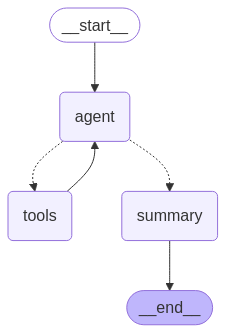

In [146]:
workflow = StateGraph(State)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("summary", summary_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")
workflow.add_edge("summary", END)
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [147]:
INITIAL_PROMPT=INITIAL_PROMPT.format(weight=90, tall=180,goal="gain muscle",sex="male",age=25,intensity="moderate")

In [157]:
config = {
    "configurable": {
        "thread_id": 17
    }
}


In [149]:
inputs = {"messages": [("user", INITIAL_PROMPT)]}
print_stream(graph.stream(inputs, config, stream_mode="values"))
# Start chatbot


================================ Human Message =================================


You are a professional fitness coach and researcher with deep expertise in
exercise science, sports physiology, nutrition, strength training,
and athletic performance.

Your mission is to help people reach their fitness goals by:
- Analyzing their current fitness level, body weghit and height

WEGHIT:90
HEIGHT:180
GOAL:gain muscle
intensity:moderate
age:25
sex:male
Equipment: local gym
Here’s how we’ll collaborate:


1.Use your knowledge and tools to search for relevant exercises from a database
   and determine optimal sets, reps, and intensity based on the user's goals.
2. Organize the workout into a structured, goal-specific plan, categorized by
   body parts (e.g., back, chest, legs) and sub-muscle groups.
3. Allow for feedback, adjustments, and improvements based on user input or
   progress tracking.
4. Output the full program in a clean, structured format that includes:
   - Exercises with primary

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01jprgek3tewht8szcvsqyx9bg` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 99562, Requested 2201. Please try again in 25m22.938999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [158]:
graph.get_state(config).values["summary_plan"].content

KeyError: 'summary_plan'

In [ ]:

inputs = {"messages": [("user", INITIAL_PROMPT)]}
print_stream(graph.stream(inputs, config, stream_mode="values"))
# Start chatbot
while True:
    user_input = input("User: ")
    inputs = {"messages": [("user", user_input)]}
    print_stream(graph.stream(inputs, config, stream_mode="values"))

================================ Human Message =================================


You are a professional fitness coach and researcher with deep expertise in
exercise science, sports physiology, nutrition, strength training,
and athletic performance.

Your mission is to help people reach their fitness goals by:
- Analyzing their current fitness level, body weghit and height

WEGHIT:90
HEIGHT:180
GOAL:gain muscle
intensity:moderate
age:25
sex:male
Equipment: local gym
Here’s how we’ll collaborate:


1.Use your knowledge and tools to search for relevant exercises from a database
   and determine optimal sets, reps, and intensity based on the user's goals.
2. Organize the workout into a structured, goal-specific plan, categorized by
   body parts (e.g., back, chest, legs) and sub-muscle groups.
3. Allow for feedback, adjustments, and improvements based on user input or
   progress tracking.
4. Output the full program in a clean, structured format that includes:
   - Exercises with primary

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01jr9pmmtyewgat985qw4prrgq` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 7465, Requested 4771. Please try again in 1m2.369s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:
class State(TypedDict):
    messages: Annotated[list,add_messages]

In [ ]:
class single_exercise(BaseModel):
    exercise: str = Field(description="exercise name")
    sub_muscles: list [str] = Field(description="list of sub_muscle in this exercise")
    primary_muscles:list [ str] = Field(description="list of primary muscle in this exercise")
    sets :str = Field(description="number of sets")
    reps: str = Field(description="number of reps")
    instruction: str = Field(description="exercise instruction")
    @property
    def summary(self):
        return f"sub_muscle: {self.sub_muscle}, exercise: {self.exercise}, sets: {self.sets}, reps: {self.reps}, details: {self.details}"
class single_body_part(BaseModel):
    body_part: str = Field(description="name of the body part")
    exercises: List[single_exercise] = Field(description="list of exercises in this body part")
    @property
    def summary(self):
        return f"body_part: {self.body_part}, exercises: {self.exercises}"
#structed_output_llm=llm.with_structured_output(single_body_part)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

# Define the prompt template with proper input variables
fitness_instructions = ChatPromptTemplate.from_template("""
You are tasked with generating a list of exercises for {body_part} that the user needs to train. Follow these instructions carefully:

1. First, review the Goal: {Goal} and the height and weight of {tall}cm and {weight}kg then specify the level of {the_level_of_cardio}.
    
2. Examine any editorial feedback: {human_feedback}

3. Take notes on the level of {intensity}

4. You can search the database for exercises by using tools

{input}
{agent_scratchpad}""")  # Required for tool calling

# Construct the tool calling agent
agent = create_tool_calling_agent(
    llm=llm,
    tools=tools,
    prompt=fitness_instructions
)

In [ ]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True,max_iterations=3)

response = agent_executor.invoke({
    "body_part": "back",
    "Goal": "gain muscle",
    "intensity": "moderate",
    "tall": 180,
    "weight": 70,
    "the_level_of_cardio": "medium",
    "human_feedback": "",
    "input": "Generate workout exercises for back",
})



> Entering new AgentExecutor chain...

Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']
Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']
Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']

> Finished chain.


In [ ]:
response

{'body_part': 'back',
 'Goal': 'gain muscle',
 'intensity': 'moderate',
 'tall': 180,
 'weight': 70,
 'the_level_of_cardio': 'medium',
 'human_feedback': '',
 'input': 'Generate workout exercises for back',
 'output': 'Agent stopped due to max iterations.'}

In [ ]:
class Generate_plans(TypedDict):
    goal:str # goal of the workout_plans
    intensity: str # intensity of the workout
    tall: int 
    weight: int
    human_feedback: str
    max_exercises: int
    muscle_workouts: List[MainMuscle] # list of whole body exercise

In [ ]:
import langchain_core

In [ ]:
fitness_instructions="""You are tasked with retreiving and review a set of exercises for each muscle group. Follow these instructions carefully:

1. First, review the research topic:
{goal}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
{human_feedback}
3. take notes on the level of {intensity} and / or feedback above.
4. Assign one set of exercises to each main muscle group.
5. Pick the top {max_exercises} exercises for each SUB muscle group."""


In [ ]:
def create_plans(state: Generate_plans):
    
    """ Create plans """
    print("i am here")
    goal=state.get('goal', '')
    intensity=state.get('intensity', '')
    human_feedback=state.get('human_feedback', '')
    max_exercises=state.get('max_exercises', 0)    
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = fitness_instructions.format(goal=goal,
                                                            human_feedback=human_feedback, 
                                                            intensity=intensity,max_exercises=max_exercises)

    # Generate question 
    main_muscle_plans = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="serach the set of exercises with serach_by_sub_muscle_tool and enhance it.")])
    
    # Write the list of analysis to state
    return {"muscle_workouts": main_muscle_plans}

In [ ]:
def search_exercises(main: str = None, sub: str = None):
    cursor = connection.cursor()
    cursor.execute(
        """
        SELECT * 
        FROM exercises
        WHERE sub_muscles LIKE ?
        OR main_muscle LIKE ?;
        """,
        (f"%{sub}%", f"%{main}%")
    )
    rows = cursor.fetchall()
    print("I am here")
    # Display the results
    return rows


In [ ]:
def human_feedback_nod(state: Generate_plans):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: Generate_plans):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_feedback', None)
    if human_analyst_feedback:
        return "create_plans"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(Generate_plans)
builder.add_node("create_plans", create_plans)
builder.add_node("human_feedback_nod", human_feedback_nod)
builder.add_edge(START, "create_plans")
builder.add_edge("create_plans", "human_feedback_nod")
builder.add_conditional_edges("human_feedback_nod", should_continue, ["create_plans", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_nod'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

NameError: name 'Generate_plans' is not defined

In [ ]:
# Input
max_exercises = 2
goal = "lose weight"
intessity = "high"
tall=178
weight=60
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"goal":goal,"max_exercises":max_exercises,"instensity":intessity}, thread, stream_mode="values"):
    # Review
    muscle_workouts = event.get('muscle_workouts', '')
    if muscle_workouts:
        for set in muscle_workouts:
            print(set)

i am here
('muscle_workouts', [{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])


In [ ]:
state = graph.get_state(thread)
print(state)

StateSnapshot(values={'goal': 'lose weight', 'max_exercises': 2, 'muscle_workouts': Perspectives(muscle_workouts=[{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])}, next=('human_feedback_nod',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb9e79-7665-6672-8001-cbe35fa2ccc6'}}, metadata={'source': 'loop', 'writes': {'create_plans': {'mus